In [5]:
import os
import json
import numpy as np
import pandas as pd

def load_or_create_data(json_path, excel_path, labels_path, video_dir, text_dir, caption_dir):
    """
    Load labels from NPY and JSON. If JSON is missing or mismatched, generate it from Excel.

    Args:
        json_path (str): path to the JSON file storing data_list
        excel_path (str): path to the Excel file containing the video list
        labels_path (str): path to the NPY file containing labels
        video_dir (str): directory containing .npy video features
        text_dir (str): directory containing .npy text features
        caption_dir (str): directory containing .npy caption features

    Returns:
        data_list (list of dict): list of dictionaries with keys 'video_feat', 'text_feat', 'caption_feat'
        labels (np.ndarray): labels
    """

    # Load labels
    if not os.path.exists(labels_path):
        raise FileNotFoundError(f"Labels file not found: {labels_path}")
    labels = np.load(labels_path)

    # Check JSON
    need_create_json = True
    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            try:
                data_list = json.load(f)
                if len(data_list) == len(labels):
                    need_create_json = False
            except json.JSONDecodeError:
                need_create_json = True

    # Create JSON 
    if need_create_json:
        if not os.path.exists(excel_path):
            raise FileNotFoundError(f"Excel file not found: {excel_path}")
        df = pd.read_excel(excel_path)
        data_list = []
        for vid in df['video_id'].astype(str):
            data_list.append({
                "name": vid,
                "video_feat": os.path.join(video_dir, f"{vid}.npy"),
                "text_feat": os.path.join(text_dir, f"{vid}.npy"),
                "caption_feat": os.path.join(caption_dir, f"{vid}.npy")
            })
        # Create folder
        os.makedirs(os.path.dirname(json_path), exist_ok=True)
        # Save JSON
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(data_list, f, ensure_ascii=False, indent=2)
        print(f"JSON created, items: {len(data_list)}")
    else:
        print(f"JSON loaded, items: {len(data_list)}")

    return data_list, labels

video_dir = "/Users/jumita/Downloads/final/frame"
text_dir = "/Users/jumita/Downloads/final/text"
caption_dir = "/Users/jumita/Downloads/final/caption"
json_path = "/Users/jumita/Downloads/final_code/data.json"
excel_path = "/Users/jumita/Downloads/Book5.xlsx"
labels_path = "/Users/jumita/Downloads/final_code/labels.npy"

data_list, labels = load_or_create_data(
    json_path=json_path,
    excel_path=excel_path,
    labels_path=labels_path,
    video_dir=video_dir,
    text_dir=text_dir,
    caption_dir=caption_dir
)



JSON loaded, items: 5047


In [6]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# ================= VIDEO FEATURE AUGMENTER =================
class VideoFeatureAugmenter:
    """
    Data augmenter for video features.

    This class applies temporal cropping and adaptive Gaussian noise 
    to video features to improve model generalization during training.

    Attributes
    ----------
    augment_prob : float
        Probability of applying augmentation.
    dropout : nn.Dropout
        Dropout layer used for augmentation (optional, not used here).
    noise_scale : float
        Scaling factor for Gaussian noise.

    Methods
    -------
    temporal_crop(features, crop_ratio=0.9):
        Randomly crops the sequence along the temporal dimension.
    adaptive_noise(features):
        Adds Gaussian noise proportional to the feature's standard deviation.
    __call__(features):
        Applies augmentation with probability `augment_prob`.
    """

    def __init__(self, augment_prob=0.5, dropout_prob=0.3, noise_scale=0.05):
        self.augment_prob = augment_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        self.noise_scale = noise_scale

    def temporal_crop(self, features, crop_ratio=0.9):
        """
        Crop the feature sequence randomly along the temporal dimension.

        Parameters
        ----------
        features : torch.Tensor
            Video feature tensor of shape (T, D) or (T, H, D).
        crop_ratio : float
            Fraction of the sequence to keep.

        Returns
        -------
        torch.Tensor
            Cropped feature tensor.
        """
        T = features.shape[0]
        new_T = int(T * crop_ratio)
        start = np.random.randint(0, T - new_T + 1)
        return features[start:start+new_T]

    def adaptive_noise(self, features):
        """
        Add Gaussian noise scaled by feature standard deviation.

        Parameters
        ----------
        features : torch.Tensor
            Feature tensor.

        Returns
        -------
        torch.Tensor
            Noisy feature tensor.
        """
        std_per_feature = features.std(dim=0, keepdim=True) + 1e-6
        noise = torch.randn_like(features) * std_per_feature * self.noise_scale
        return features + noise

    def __call__(self, features):
        """
        Apply augmentation with probability `augment_prob`.

        Parameters
        ----------
        features : torch.Tensor
            Input feature tensor.

        Returns
        -------
        torch.Tensor
            Augmented feature tensor.
        """
        if torch.rand(1) < self.augment_prob:
            if features.ndim >= 2:
                features = self.temporal_crop(features)
            features = self.adaptive_noise(features)
        return features

# ================= TEXT/CAPTION FEATURE AUGMENTER =================
class TextFeatureAugmenter:
    """
    Data augmenter for text or caption features.

    Applies dropout and adaptive Gaussian noise to embeddings.

    Attributes
    ----------
    augment_prob : float
        Probability of applying augmentation.
    dropout : nn.Dropout
        Dropout layer applied to features.
    noise_scale : float
        Scaling factor for Gaussian noise.

    Methods
    -------
    adaptive_noise(features):
        Adds Gaussian noise proportional to feature's std.
    __call__(features):
        Applies augmentation with probability `augment_prob`.
    """
    def __init__(self, augment_prob=0.3, dropout_prob=0.05, noise_scale=0.02):
        self.augment_prob = augment_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        self.noise_scale = noise_scale

    def adaptive_noise(self, features):
        """
        Add Gaussian noise scaled by feature standard deviation.

        Parameters
        ----------
        features : torch.Tensor
            Input feature tensor.

        Returns
        -------
        torch.Tensor
            Noisy feature tensor.
        """
        std_per_feature = features.std(dim=0, keepdim=True) + 1e-6
        noise = torch.randn_like(features) * std_per_feature * self.noise_scale
        return features + noise

    def __call__(self, features):
        """
        Apply dropout and noise augmentation with probability `augment_prob`.

        Parameters
        ----------
        features : torch.Tensor
            Input feature tensor.

        Returns
        -------
        torch.Tensor
            Augmented feature tensor.
        """
        if torch.rand(1) < self.augment_prob:
            features = self.dropout(features)
            features = self.adaptive_noise(features)
        return features


# ================= DATASET =================
class VideoTextCaptionDataset(Dataset):
    """
    PyTorch Dataset for multimodal video, text, and caption features.

    Handles optional data augmentation and per-sample feature normalization.

    Parameters
    ----------
    data_list : list of dict
        List of dictionaries containing paths for 'video_feat', 'text_feat', 'caption_feat'.
    labels : np.ndarray
        Array of integer labels corresponding to each sample.
    augment : bool, optional
        Whether to apply data augmentation (default: False).

    Methods
    -------
    __getitem__(idx):
        Loads, optionally augments, and returns a single sample.
    __len__():
        Returns the total number of samples.
    """
    def __init__(self, data_list, labels, augment=False):
        self.data_list = data_list
        self.labels = labels
        self.augment = augment
        self.video_aug = VideoFeatureAugmenter() if augment else None
        self.text_aug = TextFeatureAugmenter() if augment else None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Load and process a single sample.

        Returns
        -------
        dict
            Dictionary with keys: 'video_feat', 'text_feat', 'caption_feat', 'label'.
        """
        item = self.data_list[idx]

        video_feat = torch.from_numpy(np.load(item["video_feat"])).float()
        text_feat = torch.from_numpy(np.load(item["text_feat"])).float()
        caption_feat = torch.from_numpy(np.load(item["caption_feat"])).float()

        # Apply augmentation if enabled
        if self.augment:
            if self.video_aug and video_feat.ndim >= 2:  
                video_feat = self.video_aug(video_feat)
            if self.text_aug:
                text_feat = self.text_aug(text_feat)
                caption_feat = self.text_aug(caption_feat)

        # Flatten features if needed
        if video_feat.ndim == 3:
            video_feat = video_feat.mean(dim=(0,1))
        elif video_feat.ndim == 2:
            video_feat = video_feat.mean(dim=0)
        
        text_feat = text_feat if text_feat.ndim == 1 else text_feat.mean(dim=0)
        caption_feat = caption_feat if caption_feat.ndim == 1 else caption_feat.mean(dim=0)

        # Normalize each feature
        video_feat = (video_feat - video_feat.mean()) / (video_feat.std() + 1e-6)
        text_feat = (text_feat - text_feat.mean()) / (text_feat.std() + 1e-6)
        caption_feat = (caption_feat - caption_feat.mean()) / (caption_feat.std() + 1e-6)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return {
            "video_feat": video_feat,
            "text_feat": text_feat,
            "caption_feat": caption_feat,
            "label": label
        }

def create_dataloader(data_list, labels, batch_size=16, shuffle=True, augment=False):
    """
    Create a PyTorch DataLoader for the multimodal dataset.

    Parameters
    ----------
    data_list : list of dict
        List of dictionaries containing feature file paths.
    labels : np.ndarray
        Array of labels.
    batch_size : int, optional
        Batch size (default: 16).
    shuffle : bool, optional
        Whether to shuffle data (default: True).
    augment : bool, optional
        Whether to apply data augmentation (default: False).

    Returns
    -------
    DataLoader
        PyTorch DataLoader for the dataset.
    """
    dataset = VideoTextCaptionDataset(data_list, labels, augment=augment)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# ================= LOAD DATA =================
data_list, labels = load_or_create_data(
    json_path="/Users/jumita/Downloads/final_code/data.json",
    excel_path="/Users/jumita/Downloads/Book5.xlsx",
    labels_path="/Users/jumita/Downloads/final_code/labels.npy",
    video_dir="/Users/jumita/Downloads/final/frame",
    text_dir="/Users/jumita/Downloads/final/text",
    caption_dir="/Users/jumita/Downloads/final/caption"
)

# ================= SPLIT DATA =================
data_train, data_temp, labels_train, labels_temp = train_test_split(
    data_list, labels, test_size=0.2, random_state=42, stratify=labels
)

try:
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp
    )
except ValueError:
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42, stratify=None
    )

def check_overlap(set1, set2):
    s1 = set([item["video_feat"] for item in set1])
    s2 = set([item["video_feat"] for item in set2])
    return len(s1 & s2)

print("Overlap train-val:", check_overlap(data_train, data_val))
print("Overlap train-test:", check_overlap(data_train, data_test))
print("Overlap val-test:", check_overlap(data_val, data_test))


# ================= DATALOADERS =================
train_loader = create_dataloader(data_train, labels_train, batch_size=16, shuffle=True, augment=True)
val_loader = create_dataloader(data_val, labels_val, batch_size=16, shuffle=False)
test_loader = create_dataloader(data_test, labels_test, batch_size=16, shuffle=False)

# ================= DEBUG SAMPLE =================
sample = next(iter(train_loader))
print("Augmented sample shapes:")
print("Video:", sample["video_feat"].shape)
print("Text:", sample["text_feat"].shape)
print("Caption:", sample["caption_feat"].shape) 



JSON loaded, items: 5047
Overlap train-val: 0
Overlap train-test: 0
Overlap val-test: 0
Augmented sample shapes:
Video: torch.Size([16, 256])
Text: torch.Size([16, 256])
Caption: torch.Size([16, 256])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ================= StochasticDepth =================
class StochasticDepth(nn.Module):
    """
    Implements Stochastic Depth (also called DropPath) regularization.

    During training, randomly drops entire residual paths with probability `drop_prob`.

    Parameters
    ----------
    drop_prob : float
        Probability of dropping a path.
    """
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        """
        Forward pass with stochastic depth.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (B, ...).

        Returns
        -------
        torch.Tensor
            Output tensor, either dropped or scaled.
        """
        if not self.training or self.drop_prob == 0.0:
            return x
        keep_prob = 1 - self.drop_prob
        mask = (torch.rand(x.shape[0], device=x.device) < keep_prob).to(x.dtype)
        mask = mask.view(-1, *([1] * (x.dim() - 1)))
        return x * mask / keep_prob

# ================= LoRA Linear =================
class LoRALinear(nn.Module):
    """
    Linear layer with Low-Rank Adaptation (LoRA).

    Parameters
    ----------
    in_features : int
        Input feature dimension.
    out_features : int
        Output feature dimension.
    r : int
        Rank of the LoRA adaptation matrices.
    alpha : int
        Scaling factor for LoRA updates.
    """
    def __init__(self, in_features, out_features, r=6, alpha=6):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.r = r
        self.alpha = alpha
        self.scaling = self.alpha / max(1, r)
        self.linear = nn.Linear(in_features, out_features)
        if r > 0:
            self.lora_A = nn.Parameter(torch.randn(r, in_features) * 1e-3)
            self.lora_B = nn.Parameter(torch.zeros(out_features, r))
        else:
            self.lora_A = None
            self.lora_B = None

    def forward(self, x):
        """
        Forward pass through LoRA linear layer.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (B, in_features).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (B, out_features).
        """
        result = self.linear(x)
        if self.r > 0:
            lora_update = (x @ self.lora_A.T) @ self.lora_B.T
            result += lora_update * self.scaling
        return result

# ================= LoRA MultiheadAttention =================
class LoRAMultiheadAttention(nn.Module):
    """
    Multihead Attention layer with LoRA adaptation.

    Parameters
    ----------
    embed_dim : int
        Dimension of embeddings.
    num_heads : int
        Number of attention heads.
    dropout : float
        Dropout probability in attention.
    batch_first : bool
        If True, input shape is (B, S, D).
    r : int
        LoRA rank.
    alpha : int
        LoRA scaling factor.
    """
    def __init__(self, embed_dim, num_heads, dropout=0.0, batch_first=True, r=6, alpha=6):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.r = r
        self.alpha = alpha
        self.scaling = self.alpha / max(1, r)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=batch_first)
        if r > 0:
            self.lora_A_q = nn.Parameter(torch.randn(r, embed_dim) * 1e-3)
            self.lora_B_q = nn.Parameter(torch.zeros(embed_dim, r))
            self.lora_A_k = nn.Parameter(torch.randn(r, embed_dim) * 1e-3)
            self.lora_B_k = nn.Parameter(torch.zeros(embed_dim, r))
            self.lora_A_v = nn.Parameter(torch.randn(r, embed_dim) * 1e-3)
            self.lora_B_v = nn.Parameter(torch.zeros(embed_dim, r))
            self.lora_A_out = nn.Parameter(torch.randn(r, embed_dim) * 1e-3)
            self.lora_B_out = nn.Parameter(torch.zeros(embed_dim, r))

    def forward(self, query, key, value, key_padding_mask=None, need_weights=False, attn_mask=None):
        """
        Forward pass through LoRA multihead attention.

        Parameters
        ----------
        query, key, value : torch.Tensor
            Input tensors of shape (B, S, D).
        key_padding_mask : torch.Tensor, optional
            Mask for padded tokens.
        need_weights : bool
            If True, returns attention weights.
        attn_mask : torch.Tensor, optional
            Attention mask.

        Returns
        -------
        attn_output : torch.Tensor
            Attention output tensor.
        attn_weights : torch.Tensor
            Attention weights (if `need_weights` is True).
        """
        if self.r > 0:
            query = query + (query @ self.lora_A_q.T) @ self.lora_B_q.T * self.scaling
            key   = key   + (key   @ self.lora_A_k.T) @ self.lora_B_k.T * self.scaling
            value = value + (value @ self.lora_A_v.T) @ self.lora_B_v.T * self.scaling

        attn_output, attn_weights = self.attn(
            query, key, value,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            attn_mask=attn_mask
        )

        if self.r > 0:
            attn_output = attn_output + (attn_output @ self.lora_A_out.T) @ self.lora_B_out.T * self.scaling
        return attn_output, attn_weights

# ================= CoAttentionBlock =================
class CoAttentionBlock(nn.Module):
    """
    Co-Attention block between query and key/value features with LoRA and residual feed-forward.

    Parameters
    ----------
    dim_q : int
        Dimension of query features.
    dim_kv : int
        Dimension of key/value features.
    num_heads : int
        Number of attention heads.
    hidden_dim : int
        Hidden dimension for feed-forward network.
    dropout : float
        Dropout probability.
    lora_r : int
        LoRA rank.
    drop_path_prob : float
        Stochastic depth probability.
    """
    def __init__(self, dim_q=256, dim_kv=256, num_heads=8, hidden_dim=256, dropout=0.2, lora_r=6, drop_path_prob=0.2):
        super().__init__()
        self.query_proj = LoRALinear(dim_q, dim_q, r=lora_r)
        self.key_proj   = LoRALinear(dim_kv, dim_q, r=lora_r)
        self.value_proj = LoRALinear(dim_kv, dim_q, r=lora_r)
        self.attn = LoRAMultiheadAttention(dim_q, num_heads, dropout=dropout, batch_first=True, r=lora_r)
        self.gate = nn.Sequential(LoRALinear(dim_q * 2, dim_q, r=lora_r), nn.Sigmoid())
        self.ffn = nn.Sequential(
            LoRALinear(dim_q, hidden_dim, r=lora_r),
            nn.GELU(),
            nn.Dropout(dropout),
            LoRALinear(hidden_dim, dim_q, r=lora_r),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(dim_q)
        self.norm2 = nn.LayerNorm(dim_q)
        self.drop_path = StochasticDepth(drop_path_prob) if drop_path_prob > 0.0 else None

    def forward(self, query, key, value, key_padding_mask=None):
        """
        Forward pass of CoAttentionBlock.

        Parameters
        ----------
        query, key, value : torch.Tensor
            Input feature tensors.
        key_padding_mask : torch.Tensor, optional
            Mask for padded tokens.

        Returns
        -------
        torch.Tensor
            Output tensor after co-attention, gating, and feed-forward.
        """
        q = self.query_proj(query)
        k = self.key_proj(key)
        v = self.value_proj(value)
        attn_out, _ = self.attn(q, k, v, key_padding_mask=key_padding_mask)
        gate = self.gate(torch.cat([query, attn_out], dim=-1))
        out = self.norm1(query + gate * attn_out)
        ffn_out = self.ffn(out)
        if self.drop_path is not None:
            ffn_out = self.drop_path(ffn_out)
        return self.norm2(out + ffn_out)

# ================= CoAttentionLayer =================
class CoAttentionLayer(nn.Module):
    """
    Co-Attention layer for interaction between video and text features.

    It applies co-attention blocks in both directions:
    video-to-text and text-to-video, then pools the sequences
    and concatenates the outputs.

    Parameters
    ----------
    dim_q : int
        Dimension of query features (video features).
    dim_kv : int
        Dimension of key/value features (text features).
    num_heads : int
        Number of attention heads.
    hidden_dim : int
        Hidden dimension for feed-forward networks.
    dropout : float
        Dropout probability.
    lora_r : int
        LoRA rank.
    max_video_tokens : int
        Maximum number of video tokens to keep after pooling.
    """
    def __init__(self, dim_q=256, dim_kv=256, num_heads=8, hidden_dim=256, dropout=0.5, lora_r=6, max_video_tokens=32):
        super().__init__()
        self.video2text = CoAttentionBlock(dim_q, dim_kv, num_heads, hidden_dim, dropout, lora_r)
        self.text2video = CoAttentionBlock(dim_kv, dim_q, num_heads, hidden_dim, dropout, lora_r)
        self.max_video_tokens = max_video_tokens

    def forward(self, video_feat, text_feat, video_mask=None, text_mask=None):
        """
        Forward pass of co-attention layer.

        Parameters
        ----------
        video_feat : torch.Tensor
            Video features, shape (B, T, D) or (B, N, T, D) if patches.
        text_feat : torch.Tensor
            Text features, shape (B, S, D).
        video_mask : torch.Tensor, optional
            Mask for video tokens.
        text_mask : torch.Tensor, optional
            Mask for text tokens.

        Returns
        -------
        torch.Tensor
            Concatenated pooled co-attention features, shape (B, D_video + D_text).
        """
        B = video_feat.shape[0]

        # Flatten video patches if needed
        if video_feat.dim() == 4:  
            T, N, D = video_feat.shape[1], video_feat.shape[2], video_feat.shape[3]
            video_feat = video_feat.view(B, T * N, D)
        elif video_feat.dim() == 2:
            video_feat = video_feat.unsqueeze(1)

        # Pooling video sequence
        if video_feat.shape[1] > self.max_video_tokens:
            video_feat = video_feat.transpose(1, 2)  # (B, D, Seq)
            video_feat = F.adaptive_avg_pool1d(video_feat, self.max_video_tokens)
            video_feat = video_feat.transpose(1, 2)

        if text_feat.dim() == 2:
            text_feat = text_feat.unsqueeze(1)

        # Forward co-attention with optional masks
        v2t = self.video2text(video_feat, text_feat, text_feat, key_padding_mask=text_mask)
        t2v = self.text2video(text_feat, video_feat, video_feat, key_padding_mask=video_mask)
        
        # Pool sequences
        v2t_pooled = v2t.mean(dim=1)
        t2v_pooled = t2v.mean(dim=1)
        return torch.cat([v2t_pooled, t2v_pooled], dim=-1)

# ================= LateFusionLoRA =================
class LateFusionLoRA(nn.Module):
    """
    Late fusion module with LoRA for combining two feature modalities.

    Applies two-layer MLP with LayerNorm, GELU activation, dropout,
    and optional stochastic depth, then outputs class logits.

    Parameters
    ----------
    dim_feat1 : int
        Dimension of first input feature.
    dim_feat2 : int
        Dimension of second input feature.
    dim_hidden : int
        Hidden layer dimension.
    num_classes : int
        Number of output classes.
    r : int
        LoRA rank.
    """
    def __init__(self, dim_feat1, dim_feat2, dim_hidden, num_classes, r=6):
        super().__init__()
        self.fc1 = LoRALinear(dim_feat1 + dim_feat2, dim_hidden * 2, r=r)
        self.norm1 = nn.LayerNorm(dim_hidden * 2)
        self.fc2 = LoRALinear(dim_hidden * 2, dim_hidden, r=r)
        self.norm2 = nn.LayerNorm(dim_hidden)
        self.fc3 = LoRALinear(dim_hidden, num_classes, r=r)
        self.dropout = nn.Dropout(0.35)
        self.drop_path = StochasticDepth(0.2) if dim_hidden > 256 else None

    def forward(self, x1, x2):
        """
        Forward pass of late fusion module.

        Parameters
        ----------
        x1, x2 : torch.Tensor
            Input feature tensors to fuse, shape (B, dim_feat1), (B, dim_feat2).

        Returns
        -------
        torch.Tensor
            Output class logits, shape (B, num_classes).
        """
        x = torch.cat([x1, x2], dim=-1)
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.norm2(x)
        x = F.gelu(x)
        if self.drop_path is not None:
            x = self.drop_path(x)
        return self.fc3(x)

# ================= MultimodalModel =================
class MultimodalModel(nn.Module):
    """
    Multimodal model combining co-attention between video and text features
    and late fusion with caption features, with LoRA finetuning support.

    Parameters
    ----------
    video_dim : int
        Dimension of video features.
    text_dim : int
        Dimension of text features.
    caption_dim : int
        Dimension of caption features.
    hidden_dim : int
        Hidden dimension for co-attention and fusion layers.
    num_classes : int
        Number of output classes.
    r : int
        LoRA rank.
    finetune_mode : str
        Finetuning mode: 'coattn_plus_latefusion', 'late_fusion_only', 'coattn_only', etc.
    dropout_prob : float
        Dropout probability for the fusion layer.
    """
    def __init__(self, video_dim=256, text_dim=256, caption_dim=256, hidden_dim=256,
                 num_classes=3, r=6, finetune_mode: str = 'coattn_plus_latefusion',
                 dropout_prob=0.1):
        super().__init__()
        self.ca1 = CoAttentionLayer(video_dim, text_dim, num_heads=8, hidden_dim=hidden_dim, lora_r=r)
        self.fc_ca1 = LoRALinear(video_dim * 2, video_dim, r=r)
        self.dropout = nn.Dropout(dropout_prob)   
        self.late_fusion = LateFusionLoRA(video_dim, caption_dim, hidden_dim, num_classes, r=r)
        self.set_trainable(finetune_mode)

    def set_trainable(self, finetune_mode: str = 'coattn_plus_latefusion'):
        """
        Set which parameters are trainable according to finetune_mode.

        Parameters
        ----------
        finetune_mode : str
            Mode of finetuning.
        """
        for p in self.parameters():
            p.requires_grad = False

        finetune_mode = finetune_mode.lower()

        def enable_lora(module):
            for name, p in module.named_parameters():
                if "lora_A" in name or "lora_B" in name:
                    p.requires_grad = True

        def unfreeze_part(module, names_to_unfreeze):
            for name, p in module.named_parameters():
                for target_name in names_to_unfreeze:
                    if target_name in name:
                        p.requires_grad = True

        if finetune_mode == 'late_fusion_only':
            enable_lora(self.late_fusion)
            enable_lora(self.fc_ca1)
        elif finetune_mode == 'coattn_only':
            enable_lora(self.ca1)
            enable_lora(self.fc_ca1)
        elif finetune_mode == 'coattn_plus_latefusion':
            enable_lora(self.ca1)
            enable_lora(self.late_fusion)
            enable_lora(self.fc_ca1)
        elif finetune_mode == 'coattn_plus_latefusion_part':
            enable_lora(self.ca1)
            enable_lora(self.late_fusion)
            enable_lora(self.fc_ca1)
            unfreeze_part(self.ca1.video2text.query_proj, ['linear'])
            unfreeze_part(self.late_fusion.fc1, ['linear'])
        elif finetune_mode == 'all':
            for p in self.parameters():
                p.requires_grad = True
        else:
            raise ValueError(f"Unknown finetune_mode: {finetune_mode}")

    def get_param_groups(self, lr_late=2e-4, lr_coattn=1.5e-4, lr_fc_ca1=5e-5, weight_decay=5e-4):
        """
        Return parameter groups with separate learning rates for optimizer.

        Parameters
        ----------
        lr_late, lr_coattn, lr_fc_ca1 : float
            Learning rates for respective modules.
        weight_decay : float
            Weight decay for optimizer.

        Returns
        -------
        list of dict
            Parameter groups for optimizer.
        """
        groups = []
        if any(p.requires_grad for p in self.late_fusion.parameters()):
            groups.append({'params': [p for p in self.late_fusion.parameters() if p.requires_grad], 'lr': lr_late, 'weight_decay': weight_decay})
        if any(p.requires_grad for p in self.ca1.parameters()):
            groups.append({'params': [p for p in self.ca1.parameters() if p.requires_grad], 'lr': lr_coattn, 'weight_decay': weight_decay})
        if any(p.requires_grad for p in self.fc_ca1.parameters()):
            groups.append({'params': [p for p in self.fc_ca1.parameters() if p.requires_grad], 'lr': lr_fc_ca1, 'weight_decay': weight_decay})
        return groups

    def forward(self, video_feat, text_feat, caption_feat, video_mask=None, text_mask=None):
        """
        Forward pass of the multimodal model.

        Parameters
        ----------
        video_feat : torch.Tensor
            Video features.
        text_feat : torch.Tensor
            Text features.
        caption_feat : torch.Tensor
            Caption features.
        video_mask : torch.Tensor, optional
            Mask for video tokens.
        text_mask : torch.Tensor, optional
            Mask for text tokens.

        Returns
        -------
        torch.Tensor
            Class logits for each sample.
        """
        ca1_out = self.ca1(video_feat, text_feat, video_mask=video_mask, text_mask=text_mask)
        ca1_out = self.fc_ca1(ca1_out)
        ca1_out = self.dropout(ca1_out)
        return self.late_fusion(ca1_out, caption_feat)

In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os, time

# ============================= TRAINING FUNCTION =============================
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Performs one training epoch for the given model.

    Args:
        model (nn.Module): The multimodal model to train.
        dataloader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the computations on.

    Returns:
        float: Average training loss over the epoch.
    """
    model.train()
    total_loss = 0
    for batch in dataloader:
        video_feat = batch["video_feat"].to(device)
        text_feat = batch["text_feat"].to(device)
        caption_feat = batch["caption_feat"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(video_feat, text_feat, caption_feat)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * video_feat.size(0)
    return total_loss / len(dataloader.dataset)

# ============================= Metric Evaluation =============================
def compute_metrics(model, dataloader, device):
    """
    Computes accuracy, F1, precision, and recall for a given model on a dataset.

    Args:
        model (nn.Module): Trained model for evaluation.
        dataloader (DataLoader): DataLoader for evaluation data.
        device (torch.device): Device to run the computations on.

    Returns:
        dict: Dictionary containing 'acc', 'f1', 'precision', and 'recall'.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            video_feat = batch["video_feat"].to(device)
            text_feat = batch["text_feat"].to(device)
            caption_feat = batch["caption_feat"].to(device)
            labels = batch["label"].to(device)

            logits = model(video_feat, text_feat, caption_feat)
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    return {"acc": acc, "f1": f1, "precision": precision, "recall": recall}

# ============================= Ablation Model Wrapper =============================
class MultimodalModelWrapper(nn.Module):
    """
    Wrapper for a multimodal model that allows ablation studies
    by disabling certain modalities or LoRA components.

    Args:
        base_model_cls (nn.Module): Base multimodal model class.
        mode (str): Ablation mode ('full', 'without_video', 'without_text', 'without_caption', 'without_coattn', 'without_latefusion', 'without_lora').
        r (int): LoRA rank for low-rank adaptation layers.
        use_video (bool): Whether to use video modality.
        use_text (bool): Whether to use text modality.
        use_caption (bool): Whether to use caption modality.
        kwargs: Additional keyword arguments passed to the base model.
    """
    def __init__(self, base_model_cls, mode="full", r=6,
                 use_video=True, use_text=True, use_caption=True, **kwargs):
        super().__init__()
        self.mode = mode.lower()
        self.use_video = use_video
        self.use_text = use_text
        self.use_caption = use_caption

        self.model = base_model_cls(r=r, **kwargs)
        self.set_trainable_fixed(self.mode)

    def set_trainable_fixed(self, mode):
        """
        Freezes or unfreezes layers according to the ablation mode.
        """
        # First freeze all parameters
        for p in self.model.parameters():
            p.requires_grad = False

        def enable_lora(module):
            if module is not None:
                for name, p in module.named_parameters():
                    if "lora_" in name.lower():
                        p.requires_grad = True

        def unfreeze_linear(module, names_to_unfreeze):
            if module is not None:
                for name, p in module.named_parameters():
                    if any(n in name for n in names_to_unfreeze):
                        p.requires_grad = True

        if mode == "without_coattn":
            if hasattr(self.model, 'ca1'):
                for p in self.model.ca1.parameters():
                    p.requires_grad = False
            enable_lora(getattr(self.model, 'late_fusion', None))
            enable_lora(getattr(self.model, 'fc_ca1', None))
            unfreeze_linear(getattr(self.model.late_fusion, 'fc1', None), ['linear'])

        elif mode == "without_latefusion":
            if hasattr(self.model, 'late_fusion'):
                for p in self.model.late_fusion.parameters():
                    p.requires_grad = False
            enable_lora(getattr(self.model, 'ca1', None))
            enable_lora(getattr(self.model, 'fc_ca1', None))
            unfreeze_linear(getattr(self.model.ca1.video2text, 'query_proj', None), ['linear'])

        elif mode in ["without_video", "without_text", "without_caption"]:
            enable_lora(getattr(self.model, 'ca1', None))
            enable_lora(getattr(self.model, 'late_fusion', None))
            enable_lora(getattr(self.model, 'fc_ca1', None))
            unfreeze_linear(getattr(self.model.ca1.video2text, 'query_proj', None), ['linear'])
            unfreeze_linear(getattr(self.model.late_fusion, 'fc1', None), ['linear'])

        elif mode == "without_lora":
            # Do not use LoRA
            for p in self.model.parameters():
                p.requires_grad = True

        else:  # full mode
            enable_lora(getattr(self.model, 'ca1', None))
            enable_lora(getattr(self.model, 'late_fusion', None))
            enable_lora(getattr(self.model, 'fc_ca1', None))
            unfreeze_linear(getattr(self.model.ca1.video2text, 'query_proj', None), ['linear'])
            unfreeze_linear(getattr(self.model.late_fusion, 'fc1', None), ['linear'])

    def forward(self, video_feat, text_feat, caption_feat, video_mask=None, text_mask=None):
        """
        Forward pass through the model with optional modality masking.

        Args:
            video_feat (Tensor): Video features tensor.
            text_feat (Tensor): Text features tensor.
            caption_feat (Tensor): Caption features tensor.
            video_mask (Tensor, optional): Mask for video tokens.
            text_mask (Tensor, optional): Mask for text tokens.

        Returns:
            Tensor: Output logits from the model.
        """
        if not self.use_video:
            video_feat = torch.zeros_like(video_feat).to(video_feat.device)
            video_mask = None
        if not self.use_text:
            text_feat = torch.zeros_like(text_feat).to(text_feat.device)
            text_mask = None
        if not self.use_caption:
            caption_feat = torch.zeros_like(caption_feat).to(caption_feat.device)

        return self.model(video_feat, text_feat, caption_feat,
                          video_mask=video_mask, text_mask=text_mask)

# ============================= Early Stopping =============================
class EarlyStopping:
    """
    Early stopping utility to stop training when validation metric stops improving.

    Args:
        patience (int): Number of epochs with no improvement after which training is stopped.
        delta (float): Minimum change in the monitored metric to qualify as improvement.
        verbose (bool): Whether to print early stopping messages.
        mode (str): 'min' for loss, 'max' for accuracy or metric to maximize.
    """
    def __init__(self, patience=10, delta=0.0, verbose=False, mode='min'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, metric_value):
        """
        Checks if training should stop based on the provided metric.

        Args:
            metric_value (float): Current value of the monitored metric.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.mode == 'min':
            score = -metric_value
        else:
            score = metric_value
            
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

# ============================= Trainer =============================
class MultimodalTrainer:
    """
    Trainer class for multimodal models with gradient accumulation, early stopping, and checkpointing.

    Args:
        model (nn.Module): Model to train.
        device (torch.device): Device for training.
        optimizer (torch.optim.Optimizer): Optimizer.
        criterion (nn.Module): Loss function.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        grad_accum_steps (int): Number of steps to accumulate gradients.
        max_grad_norm (float): Maximum gradient norm for clipping.
    """
    def __init__(self, model, device, optimizer, criterion, scheduler=None, grad_accum_steps=2, max_grad_norm=1.0):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.grad_accum_steps = grad_accum_steps
        self.max_grad_norm = max_grad_norm
        self.best_metrics = {'acc': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'epoch': 0}

    def _to_device(self, batch):
        """
        Moves batch data to the specified device.

        Args:
            batch (dict): Dictionary of tensors.

        Returns:
            dict: Dictionary with tensors on the correct device.
        """
        return {k: v.to(self.device) for k, v in batch.items()}

    def train_epoch(self, train_loader):
        """
        Performs a single training epoch with optional gradient accumulation.

        Args:
            train_loader (DataLoader): DataLoader for training data.

        Returns:
            tuple:
                - float: Average training loss over the epoch.
                - float: Training accuracy over the epoch.
        """
        self.model.train()
        total_loss, correct, total = 0, 0, 0
        self.optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(train_loader):
            batch = self._to_device(batch)
            outputs = self.model(batch['video_feat'], batch['text_feat'], batch['caption_feat'])
            loss = self.criterion(outputs, batch['label']) / self.grad_accum_steps
            loss.backward()

            if (batch_idx + 1) % self.grad_accum_steps == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
                self.optimizer.step()
                self.optimizer.zero_grad()

            total_loss += loss.item() * batch['label'].size(0) * self.grad_accum_steps
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch['label']).sum().item()
            total += batch['label'].size(0)
            
        # Handle remaining gradients if any
        if total % self.grad_accum_steps != 0:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        return total_loss / total, correct / total

    def validate(self, val_loader):
        """
        Evaluates the model on the validation set.

        Args:
            val_loader (DataLoader): DataLoader for validation data.

        Returns:
            dict: Dictionary containing validation metrics: 'acc', 'f1', 'precision', 'recall'.
        """
        return compute_metrics(self.model, val_loader, self.device)

    def train(self, train_loader, val_loader, num_epochs=25, patience=10, checkpoint_dir="checkpoints"):
        """
        Trains the model over multiple epochs, applying early stopping and checkpointing.

        Args:
            train_loader (DataLoader): DataLoader for training data.
            val_loader (DataLoader): DataLoader for validation data.
            num_epochs (int): Maximum number of epochs to train.
            patience (int): Number of epochs to wait for improvement before early stopping.
            checkpoint_dir (str): Directory to save the best model checkpoint.

        Returns:
            dict: Best validation metrics achieved during training including 'acc', 'f1', 'precision', 'recall', 'epoch'.
        """
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
        early_stopping = EarlyStopping(patience=patience, verbose=True, mode='max')
        start_time = time.time()

        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_metrics = self.validate(val_loader)
            val_acc = val_metrics["acc"]

            metric_for_scheduler = 1 - val_acc
            if self.scheduler:
                self.scheduler.step(metric_for_scheduler)
            # Update best metrics
            if val_acc > self.best_metrics['acc']:
                self.best_metrics = val_metrics.copy()
                self.best_metrics['epoch'] = epoch + 1
                torch.save(self.model.state_dict(), checkpoint_path)

            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_metrics['acc']:.4f}, F1: {val_metrics['f1']:.4f}")

            if early_stopping(val_acc):
                print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {self.best_metrics['acc']:.4f}")
                break

        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time//60:.0f}m {total_time%60:.0f}s. Best Val Acc: {self.best_metrics['acc']:.4f}")

        # Load best model
        if os.path.exists(checkpoint_path):
            self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        return self.best_metrics

# ============================= Ablation Runner =============================
def run_ablation(base_model_cls, train_loader, val_loader, test_loader,
                 device, num_classes=3, num_epochs=25, patience=10, hidden_dim=256):
    """
    Performs an ablation study by training and evaluating the model with different components removed.

    Args:
        base_model_cls (nn.Module): Base multimodal model class.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        test_loader (DataLoader): Test data loader.
        device (torch.device): Device for training and evaluation.
        num_classes (int): Number of output classes.
        num_epochs (int): Maximum number of epochs to train.
        patience (int): Patience for early stopping.
        hidden_dim (int): Hidden dimension size for intermediate layers.

    Returns:
        dict: Returns results for each ablation mode, including validation and test metrics.
    """
    ablation_modes = [
        ("without_coattn", True, True, True),
        ("without_latefusion", True, True, True),
        ("without_video", False, True, True),
        ("without_text", True, False, True),
        ("without_caption", True, True, False),
        ("without_lora", True, True, True), 
    ]


    results = {}

    for mode_name, use_video, use_text, use_caption in ablation_modes:
        print(f"\n=== Running Ablation: {mode_name} ===")

        model = MultimodalModelWrapper(
            base_model_cls,
            mode=mode_name,
            r=6,
            video_dim=256,
            text_dim=256,
            caption_dim=256,
            hidden_dim=hidden_dim,
            num_classes=num_classes,
            use_video=use_video,
            use_text=use_text,
            use_caption=use_caption
        )

        class_weights = torch.tensor([1.22, 0.90, 0.94], device=device)
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.08)
        params_to_update = [
            {"params": model.model.ca1.parameters(), "lr": 1.5e-4},
            {"params": model.model.late_fusion.parameters(), "lr": 1.5e-4},
            {"params": model.model.fc_ca1.parameters(), "lr": 5e-5},
        ]

        optimizer = torch.optim.AdamW(params_to_update, weight_decay=5e-4)        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

        trainer = MultimodalTrainer(model=model, device=device, optimizer=optimizer, 
                                  criterion=criterion, scheduler=scheduler)
        checkpoint_dir = f"checkpoints_ablation/{mode_name}"

        best_val_metrics = trainer.train(train_loader, val_loader, num_epochs=num_epochs, 
                                       patience=patience, checkpoint_dir=checkpoint_dir)

        test_metrics = compute_metrics(model, test_loader, device)
        results[mode_name] = {"test": test_metrics, "val": best_val_metrics}

    print("\n=== Ablation Table (Test Set) ===")
    print(f"{'Mode':<20} | {'Acc':<6} | {'F1':<6} | {'Prec':<6} | {'Recall':<6}")
    print("-" * 60)
    for mode, metrics in results.items():
        m = metrics["test"]
        print(f"{mode:<20} | {m['acc']:.4f} | {m['f1']:.4f} | {m['precision']:.4f} | {m['recall']:.4f}")

    return results

# ============================= RUN =============================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
results = run_ablation(MultimodalModel, train_loader, val_loader, test_loader,
                       device=device, num_classes=3, num_epochs=25, hidden_dim=256)



=== Running Ablation: without_coattn ===
Epoch 1/25 | Train Loss: 0.9996, Acc: 0.5177 | Val Acc: 0.5861, F1: 0.5858
Epoch 2/25 | Train Loss: 0.9031, Acc: 0.6019 | Val Acc: 0.6554, F1: 0.6553
Epoch 3/25 | Train Loss: 0.8548, Acc: 0.6393 | Val Acc: 0.6396, F1: 0.6383
EarlyStopping counter: 1 / 10
Epoch 4/25 | Train Loss: 0.8258, Acc: 0.6542 | Val Acc: 0.6535, F1: 0.6545
EarlyStopping counter: 2 / 10
Epoch 5/25 | Train Loss: 0.7914, Acc: 0.6901 | Val Acc: 0.6693, F1: 0.6684
Epoch 6/25 | Train Loss: 0.7784, Acc: 0.6953 | Val Acc: 0.6653, F1: 0.6658
EarlyStopping counter: 1 / 10
Epoch 7/25 | Train Loss: 0.7517, Acc: 0.7154 | Val Acc: 0.6772, F1: 0.6769
Epoch 8/25 | Train Loss: 0.7326, Acc: 0.7275 | Val Acc: 0.6871, F1: 0.6865
Epoch 9/25 | Train Loss: 0.7186, Acc: 0.7317 | Val Acc: 0.6871, F1: 0.6866
Epoch 10/25 | Train Loss: 0.7015, Acc: 0.7451 | Val Acc: 0.6911, F1: 0.6904
Epoch 11/25 | Train Loss: 0.6940, Acc: 0.7511 | Val Acc: 0.6970, F1: 0.6953
Epoch 12/25 | Train Loss: 0.6712, Acc: 0.

In [13]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import logging

# ============================== LOGGING =============================
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("peft").setLevel(logging.ERROR)

# ============================== DEVICE ==============================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# ===================== LOAD DATASET (TEST LOADER) ===================
test_loader = create_dataloader(data_test, labels_test, batch_size=16, shuffle=False)

# ================ DEFINE MODEL CREATION FUNCTION ===================
def create_multimodal_model():
    return MultimodalModel(
        video_dim=256,
        text_dim=256,
        caption_dim=256,
        hidden_dim=256,
        num_classes=3,
        r=6
    )

# ==================== ENSEMBLE PREDICTION FUNCTION ===================
def ensemble_predict(batch, models, device):
    batch = {k: v.to(device) for k, v in batch.items()}
    probs = []
    with torch.no_grad():
        for model in models:
            output = model(batch['video_feat'], batch['text_feat'], batch['caption_feat'])
            probs.append(torch.softmax(output, dim=1))
    avg_probs = torch.stack(probs).mean(dim=0)
    return avg_probs.argmax(dim=1)

# ======================= LOAD 3-fold MODELS ==========================
model_paths = [
    "/Users/jumita/Downloads/checkpoints_fold_1/best_model.pth",
    "/Users/jumita/Downloads/checkpoints_fold_2/best_model.pth",
    "/Users/jumita/Downloads/checkpoints_fold_3/best_model.pth"
]

fold_models = []
for path in model_paths:
    model = create_multimodal_model().to(device)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    fold_models.append(model)

# ======================== RUN ERROR ANALYSIS ==========================
all_preds = []
all_labels = []
misclassified = []

sample_index = 0  # keep track of global index
for batch in test_loader:
    labels = batch['label'].numpy()
    preds = ensemble_predict(batch, fold_models, device).cpu().numpy()
    
    all_preds.extend(preds)
    all_labels.extend(labels)
    
    for i, (p, l) in enumerate(zip(preds, labels)):
        if p != l:
            misclassified.append({
                'sample_index': sample_index,
                'pred': int(p),
                'label': int(l)
            })
        sample_index += 1

# ========================== COMPUTE METRICS ===========================
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Set Metrics:\nAcc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
print(f"Total misclassified samples: {len(misclassified)}")

# ======================= SAVE MISCLASSIFIED ===========================
df_misclassified = pd.DataFrame(misclassified)
df_misclassified.to_csv("misclassified_samples.csv", index=False)
print("Saved misclassified samples to misclassified_samples.csv")

# ================ Example misclassified samples ========================
print("\nExample misclassified samples (first 5):")
print(df_misclassified.head(5))


Test Set Metrics:
Acc: 0.8099, Prec: 0.8174, Rec: 0.8099, F1: 0.8096
Total misclassified samples: 96
Saved misclassified samples to misclassified_samples.csv

Example misclassified samples (first 5):
   sample_index  pred  label
0             0     0      2
1            14     1      2
2            23     1      2
3            25     0      1
4            26     0      1


/var/folders/8g/mh4k3gks5ps1hxj4j0qrsd9r0000gn/T/ipykernel_82191/3843102682.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_pairs, y=counts_pairs, ax=axes[0], palette="coolwarm")
/var/folders/8g/mh4k3gks5ps1hxj4j0qrsd9r0000gn/T/ipykernel_82191/3843102682.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts_ordered, ax=axes[1], palette="magma")


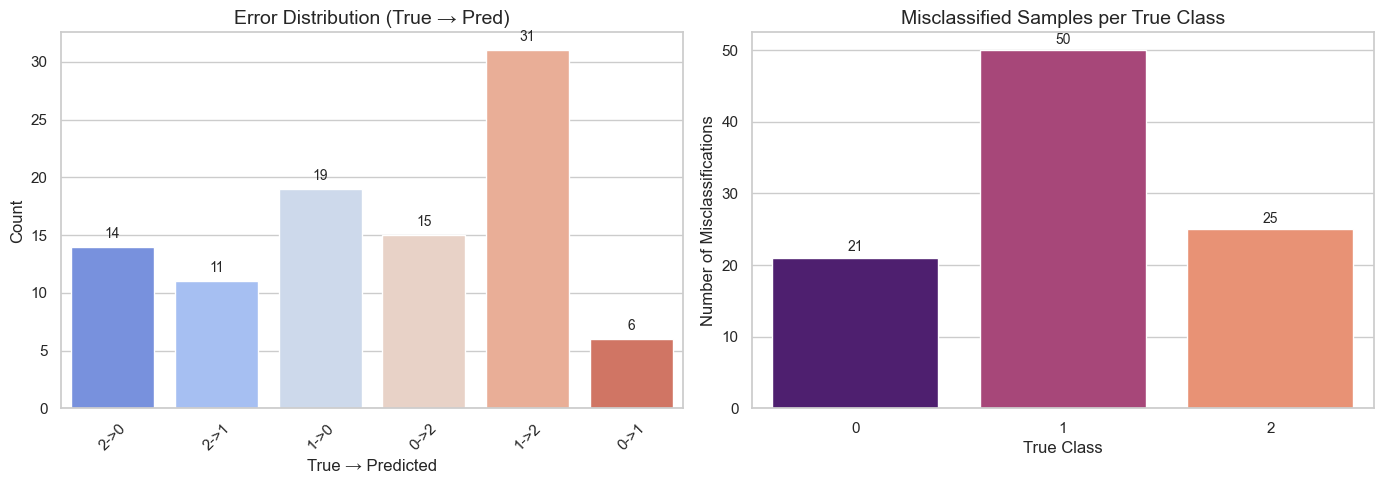

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ==================== PREP DATA ====================
# Error distribution: True → Pred
error_pairs = [(m['label'], m['pred']) for m in misclassified]
pair_counts = Counter(error_pairs)
labels_pairs = [f"{l}->{p}" for (l, p) in pair_counts.keys()]
counts_pairs = [count for count in pair_counts.values()]

# Misclassified count per true class
true_labels = [m['label'] for m in misclassified]
label_counts = Counter(true_labels)
classes = sorted(set(true_labels))
counts_ordered = [label_counts.get(c, 0) for c in classes]

# ==================== PLOT =========================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ----- Left: Error Distribution -----
sns.barplot(x=labels_pairs, y=counts_pairs, ax=axes[0], palette="coolwarm")
axes[0].set_title("Error Distribution (True → Pred)", fontsize=14)
axes[0].set_xlabel("True → Predicted", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# ----- Right: Misclassified Count per True Class -----
sns.barplot(x=classes, y=counts_ordered, ax=axes[1], palette="magma")
axes[1].set_title("Misclassified Samples per True Class", fontsize=14)
axes[1].set_xlabel("True Class", fontsize=12)
axes[1].set_ylabel("Number of Misclassifications", fontsize=12)

# Thêm số count trên cột
for ax, counts in zip([axes[0], axes[1]], [counts_pairs, counts_ordered]):
    for idx, val in enumerate(counts):
        ax.text(idx, val + 0.5, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("misclassified_analysis_combined.png", dpi=300)
plt.show()
